# Applications: Econometrics

In this unit, we study a few more advanced examples of how to use Python
to perform common econometric tasks. We will go beyond just calling existing
functions that someone implemented, but we instead will implement these
ourselves to understand the underlying concepts.

## Preliminaries: Drawing bivariate samples

In most of the exercises below, we'll need to draw a random sample that serves as an input. 
We therefore first define a routine which returns a sample drawn from a bivariate normal distribution.

In line with what we learned in unit 10, we check arguments and raise an exception if a an invalid value is encountered.

In [1]:
import numpy as np
from numpy.random import default_rng

def draw_bivariate_sample(mean, std, rho, n, seed=123):
    """
    Draw a bivariate normal random sample.

    Parameters
    ----------
    mean : array_like
        Length-2 array of means
    std : array_like
        Length-2 array of standard deviations
    rho : float
        Correlation parameter
    n : int
        Sample size
    """

    if not -1 <= rho <= 1:
        raise ValueError(f'Invalid correlation parameter: {rho}')

    if np.any(np.array(std) <= 0):
        raise ValueError(f'Invalid standard deviation: {std}')

    if n <= 0:
        raise ValueError(f'Invalid sample size: {n}')

    # initialize default RNG with given seed
    rng = default_rng(seed)

    # Unpack standard deviations for each dimension
    std1, std2 = std

    # Compute covariance
    cov = rho * std1 * std2

    # Create variance-covariance matrix
    vcv = np.array([[std1**2.0, cov],
                    [cov, std2**2.0]])

    # Draw MVN random numbers:
    # each row represents one sample draw.
    X = rng.multivariate_normal(mean=mean, cov=vcv, size=n)

    return X

***

## Singular value decomposition (SVD) and principal components

Singular value decomposition is a matrix factorisation that is commonly used in econometrics and statistics. 
For example, we can use it to implement principal component analysis (PCA),
principal component regression, OLS or Ridge regression.

Let $\mathbf{X} \in \mathbb{R}^{m\times n}$ be a matrix. For our purposes, we will assume
that $m \geq n$ since $\mathbf{X}$ will be the matrix containing the data with
observations in rows and variables in column.
The (compact) SVD of $\mathbf{X}$ is given by
$$\mathbf{X} = \mathbf{U} \Sigma \mathbf{V}'$$
where $\mathbf{U} \in \mathbb{R}^{m\times n}$ and 
$\mathbf{V} \in \mathbb{R}^{n\times n}$ are orthogonal matrices,
and $\Sigma \in \mathbb{R}^{n \times n}$ is a diagonal matrix
$$\Sigma =  \begin{bmatrix} 
    \sigma_1 & & & & \\
     & \sigma_2 & & & \\
     & & \ddots & & \\
     & & & \sigma_n & 
\end{bmatrix}$$
The elements $\sigma_i$ are called singular values of $\mathbf{X}$, and $\Sigma$
is arranged such that $\sigma_1 \geq \sigma_2 \geq \dots \geq \sigma_n$.
Since $\mathbf{U}$ is not necessarily square, it's not truly orthogonal, but its
columns are still orthogonal to each other.

These matrices satisfy the following useful properties:
$$
\def\bV{\mathbf{V}}
\def\bU{\mathbf{U}}
\def\bI{\mathbf{I}}
\begin{aligned}
    \bU' \bU &= \bI_n \\
    \bV' \bV &= \bV\bV' = \bI_n \\
    \bV' &= \bV^{-1}
\end{aligned}
$$

In Python, we compute the SVD using the 
[`svd()`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html) 
function from `numpy.linalg`.

### Example: Bivariate normal

Imagine we construct $X$ as 200 random draws from a bivariate normal:

Text(0.5, 1.0, 'Draws from bivariate normal distribution')

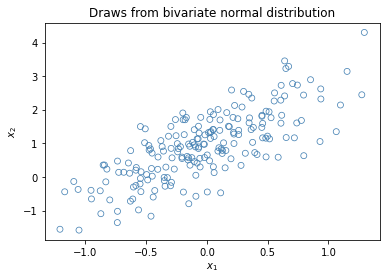

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import default_rng

# Draw a bivariate normal sample using the function we defined above
mu = [0.0, 1.0]         # Vector of means
sigma = [0.5, 1.0]      # Vector of standard deviations
rho = 0.75              # Correlation coefficient
Nobs = 200              # Sample size
X = draw_bivariate_sample(mu, sigma, rho, Nobs)
x1, x2 = X.T

# Scatter plot of sample
plt.scatter(x1, x2, linewidths=0.75, c='none', edgecolors='steelblue')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title('Draws from bivariate normal distribution')

We can now perform the SVD as follows:

In [3]:
from numpy.linalg import svd

# svd() returns transposed V!
# We use full_matrices=False to get the compact factorisation, otherwise
# U is 200 x 200.
U, S, Vt = svd(X, full_matrices=False)

In [4]:
# Check that U'U is a 2x2 identity matrix
U.T @ U         # or np.dot(U.T, U)

array([[ 1.00000000e+00, -6.12878704e-17],
       [-6.12878704e-17,  1.00000000e+00]])

In [5]:
# Check that V'V = VV' is a 2x2 identity matrix
Vt.T @ Vt       # or np.dot(Vt.T, Vt)

array([[ 1.00000000e+00, -2.26167254e-18],
       [-2.26167254e-18,  1.00000000e+00]])

In [6]:
# svd() does not return S as a matrix but only its diagonal!
S

array([19.73152572,  5.99498933])

In [7]:
# We can convert it to a diagonal matrix using np.diag()
np.diag(S)

array([[19.73152572,  0.        ],
       [ 0.        ,  5.99498933]])

Finally, we can multiply the output of `svd()` to verify that the result is
equal to $\mathbf{X}$:

In [8]:
X_svd = U * S @ Vt

# Compute the max. absolute difference
diff = np.amax(np.abs(X - X_svd) )
print(f"Max. absolute difference between X and USV': {diff:.2e}")

Max. absolute difference between X and USV': 2.89e-15


### Example: Principal components

We use principal component analysis (PCA) as a dimension reduction technique,
which allows us to identify an alternate set of axes along which the data
in $\mathbf{X}$ varies the most. In machine learning, PCA is one of the
most basic unsupervised learning techniques.

To perform the PCA, it is recommended to first demean the data:

In [9]:
X = draw_bivariate_sample(mu, sigma, rho, Nobs)

# Demean variables in X
Xmean = np.mean(X, axis=0)

# Matrix Z stores the demeaned variables
Z = X - Xmean[None]

We can now use the SVD factorisation to compute the principal components. 
Once we have computed the matrices $\mathbf{U}$, $\Sigma$ and $\mathbf{V}$,
the matrix of principal components (one in each column) is given by
$$
PC = \mathbf{U} \Sigma
$$

In [10]:
# Apply SVD to standardised values
U, S, Vt = svd(Z, full_matrices=False)

# Compute principal components
PC = U * S          # same as U @ np.diag(S)

# Variance is highest for first component
var_PC = np.var(PC, axis=0, ddof=1)
print(f'Principal component variances: {var_PC}')

Principal component variances: [1.17607859 0.09444617]


We can plot the principal component axes in the original data space (left columns).
Moreover, the right column shows the data rotated and rescaled so that each
axes corresponds to a principal component. Most of the variation
clearly occurs along the first axis!

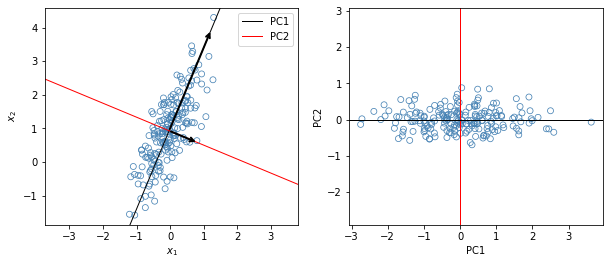

In [11]:
# Plot principal components

# Scatter plot of sample
fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].scatter(X[:, 0], X[:, 1], linewidths=0.75, c='none', edgecolors='steelblue')
axes[0].axis('equal')
axes[0].set_xlabel(r'$x_1$')
axes[0].set_ylabel(r'$x_2$')
axes[0].axline(Xmean, Xmean + Vt[0], label='PC1', lw=1.0, c='black', zorder=1)
axes[0].axline(Xmean, Xmean + Vt[1], label='PC2', lw=1.0, c='red', zorder=1)

PC_arrows = Vt * np.sqrt(var_PC[:, None])
for v in PC_arrows:
    # Scale up arrows by 3 so that they are visible!
    axes[0].annotate('', Xmean + v*3, Xmean, arrowprops=dict(arrowstyle='->', linewidth=2))

axes[0].legend()

# Plot in principal component coordinate system
axes[1].scatter(PC[:, 0], PC[:, 1], linewidths=0.75, c='none', edgecolors='steelblue')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].axis('equal')
axes[1].axvline(0.0, lw=1.0, c='red')
axes[1].axhline(0.0, lw=1.0, c='black')

Of course, in real applications we don't need to manually compute the
principal components, but can use a library such as 
[scikit-learn](https://scikit-learn.org/stable/) to do it for us:

In [12]:
from sklearn.decomposition import PCA

# Draw the same sample as before
X = draw_bivariate_sample(mu, sigma, rho, Nobs)

# Create PCA with 2 components (which is the max, since we have only two 
# variables)
pca = PCA(n_components=2)

# Perform PCA on input data
pca.fit(X)

# The attribute components_ can be used to retrieve the V' matrix
print("Principal components (matrix V'):")
print(pca.components_)

# The attribute explained_variance_ stores the variances of all PCs
print(f'Variance of each PC: {pca.explained_variance_}')

# Fraction of variance explained by each component:
print(f'Fraction of variance of each PC: {pca.explained_variance_ratio_}')

Principal components (matrix V'):
[[ 0.38420018  0.92324981]
 [ 0.92324981 -0.38420018]]
Variance of each PC: [1.17607859 0.09444617]
Fraction of variance of each PC: [0.92566365 0.07433635]


***

## Ordinary least squares (OLS)

Consider the regression 
$$
y_i = \mathbf{x}_i' \beta + u_i
$$
where $\mathbf{x}_i$ is a vector of regressors (explanatory variables) 
that is assumed to include a constant.
Recall that the OLS estimator $\widehat{\beta}$ is given by 
$$
\def\bX{\mathbf{X}}
\def\bY{\mathbf{y}}
\widehat{\beta} = \left(\bX'\bX\right)^{-1}\bX'\bY
$$
where $\mathbf{X}$ is the regressor matrix that contains all stacked $\mathbf{x}_i'$,
and $\mathbf{y}$ contains all observations of the dependent variable.

### Example 1: Bivariate data

We first demonstrate how to run OLS using bivariate normal data.
With only one regressor, the regression simplifies to
$$
y_i = \alpha + \beta x_i + u_i
$$
where $\alpha$ is the intercept and $\beta$ is the slope coefficient.
In this special case, the population coefficient $\beta$ can be computed 
using the formula
$$
\beta = \frac{E[(Y-\overline{Y})(X-\overline{X})]}{E[(X-\overline{X})]}
 = \frac{Cov(Y,X)}{Var(X)}
$$
where the numerator contains the covariance of the random variables $Y$ and $X$, 
and the denominator contains the variance of $X$.
Given a sample of values, the estimator $\widehat{\beta}$
is computed using the corresponding sample moments:
$$
\widehat{\beta} = \frac{\widehat{Cov}(y,x)}{\widehat{Var}(x)}
$$

Slope of population regression line: -1.5
Slope of sample regression line: -1.3889613032802288


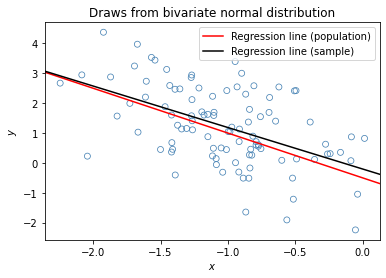

In [13]:
import numpy as np
import matplotlib.pyplot as plt

mu = [-1.0, 1.0]                # Mean of X and Y
std = [0.5, 1.5]                # Std. dev. of X and Y
rho = -0.5                      # Correlation coefficient
Nobs = 100                      # Sample size

# We transpose the return value and unpack individual rows into X and Y
x, y = draw_bivariate_sample(mu, std, rho, Nobs).T

# Compute beta (slope coefficient) from distribution moments.
# This is the true underlying relationship given our data generating process.
cov = rho * np.prod(std)
beta = cov / std[0]**2.0
print(f'Slope of population regression line: {beta}')

# Compute beta from sample moments
# Sample variance-covariance matrix (ddof=1 returns the unbiased estimate)
cov_hat = np.cov(x, y, ddof=1)[0, -1]
var_x_hat = np.var(x, ddof=1)
beta_hat = cov_hat / var_x_hat
# Sample intercept
alpha_hat = np.mean(y) - beta_hat * np.mean(x)

print(f'Slope of sample regression line: {beta_hat}')

# Scatter plot of sample
plt.scatter(x, y, linewidths=0.75, c='none', edgecolors='steelblue')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title('Draws from bivariate normal distribution')
plt.axline(mu, slope=beta, color='red', label='Regression line (population)')
plt.axline((0, alpha_hat), slope=beta_hat, color='black', label='Regression line (sample)')
plt.legend()

### Example 2: OLS using matrix algebra

With more than one regressor, we need to use matrix algebra to perform
the OLS estimation. For demonstration purposes, we continue
using the bivariate data generated above, but now we write the OLS regression
as
$$
y_i = \mathbf{x}_i' \gamma + u_i
$$
where $\gamma = (\alpha, \beta)$, and the regressors now contain a constant,
$\mathbf{x_i} = (1, x_i)'$. As stated above, the OLS estimator
is given by
$$
\def\bX{\mathbf{X}}
\widehat{\gamma} = \left(\bX'\bX\right)^{-1}\bX'\mathbf{y}
$$

#### Naive solution

You might be tempted to solve the above equation system by explicitly 
computing the inverse of $\mathbf{X}'\mathbf{X}$ using NumPy's 
[`inv()`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.inv.html)
like this:

In [14]:
from numpy.linalg import inv

# We transpose the return value and unpack individual rows into X and Y
x, y = draw_bivariate_sample(mu, std, rho, Nobs).T

# Create vector of ones (required to estimate the intercept)
ones = np.ones((len(x), 1))
# Prepend constant to vector of regressors to create regressor matrix X
X = np.hstack((ones, x[:, None]))

# Compute inverse of X'X
XXinv = inv(X.T @ X)

print("Explicitly computed (X'X)^(-1):")
print(XXinv)

# Compute naive estimate of gamma
gamma_naive = XXinv @ X.T @ y
print(f'Naive estimate of gamma: {gamma_naive}')

Explicitly computed (X'X)^(-1):
[[0.05633363 0.04521468]
 [0.04521468 0.04412275]]
Naive estimate of gamma: [-0.20352351 -1.3889613 ]


This might seems like a straightforward way to implement OLS, but in
practice you should *never* do this. Explicitly taking the inverse of a matrix to solve an equation system is rarely a good idea and numerically unstable, even though in this particular
case it yields the same result!

#### Solving as a linear equation system

One numerically acceptable way to run OLS is to view it as a linear equation system.
Recall that a linear equation system can be written in matrix notation as
$$
\mathbf{A} \mathbf{z} = \mathbf{b}
$$
where $\mathbf{A} \in \mathbb{R}^{k \times k}$ is a coefficient matrix of full rank, 
$\mathbf{b} \in \mathbb{R}^k$ is a vector, and 
$\mathbf{z} \in \mathbb{R}^k$ is a vector of $k$ unknows we want to solve for. The OLS
estimator can be written in this form if we set
$$
\begin{aligned}
    \mathbf{A} &= \mathbf{X}'\mathbf{X} \\
    \mathbf{b} &= \mathbf{X}'\mathbf{y} \\
    \mathbf{z} &= \widehat{\gamma}
\end{aligned}
$$
so that we have
$$
    (\mathbf{X}'\mathbf{X})\widehat{\gamma} = \mathbf{X}'\mathbf{y}
$$
We can use NumPy's [`solve()`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.solve.html)
to find $\widehat{\gamma}$:

In [15]:
from numpy.linalg import solve

# Compute X'X
A = X.T @ X
# Compute X'y
b = X.T @ y

# Solve for coefficient vector
gamma_solve = solve(A, b)
print(f'Estimate of gamma using solve(): {gamma_solve}')

Estimate of gamma using solve(): [-0.20352351 -1.3889613 ]


Of course, running OLS (or equivalently: solving an overdetermined
linear equation system) is a common task, so NumPy has the 
function 
[`lstsq()`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html)
which allows you do to it without explicitly computing
$\mathbf{X}'\mathbf{X}$ or $\mathbf{X}'\mathbf{y}$:

In [16]:
from numpy.linalg import lstsq

# Estimate using lstsq(). Pass rcond=None to suppress a warning.
gamma_lstsq, *rest = lstsq(X, y, rcond=None)

print(f'Estimate of gamma using lstsq(): {gamma_lstsq}')

Estimate of gamma using lstsq(): [-0.20352351 -1.3889613 ]


### Example 3: Implementing OLS yourself

NumPy's `lstsq()` uses SVD to compute the solution. Since we covered
SVD in a previous exercise, we already have the tools to build our own implementation.

Recall that SVD factorises a regressor matrix $\mathbf{X}$ into three 
matrices,
$$
\mathbf{X} = \mathbf{U} \Sigma \mathbf{V}'
$$
We can use the orthogonality properties of $\mathbf{U}$ and $\mathbf{V}$
described above to transform the OLS estimator. 
We will be using the fact that the transpose of $\mathbf{X}$ is 
$$
\mathbf{X}' = \mathbf{V} \Sigma' \mathbf{U}' = 
    \mathbf{V} \Sigma \mathbf{U}'
$$
which follows since $\Sigma$ is a diagonal (and thus symmetric) matrix.
The OLS estimator can then be expressed as follows:
$$
\def\bV{\mathbf{V}}
\def\bX{\mathbf{X}}
\def\bU{\mathbf{U}}
\def\bY{\mathbf{y}}
\def\ident{\mathbf{I}}
\begin{aligned}
\widehat{\gamma} &= (\mathbf{X}'\mathbf{X})^{-1}\mathbf{X}'\mathbf{y} \\
    &= \left(\bV \Sigma \bU' \bU \Sigma \bV' \right)^{-1}
        \bV \Sigma \bU' \bY \\
    &= \left(\bV \Sigma \ident_k \Sigma \bV' \right)^{-1}
        \bV \Sigma \bU' \bY \\
    &= \left(\bV \Sigma^2 \bV' \right)^{-1}
        \bV \Sigma \bU' \bY \\
\end{aligned}
$$
This follows since $\mathbf{U}'\mathbf{U} = \mathbf{I}_k$ is an identity matrix where $k=2$
is the number of coefficients we are estimating.
Next, we can compute the inverse using the orthogonality properties of 
$\mathbf{V}$,
$$
\def\bV{\mathbf{V}}
\begin{aligned}
    \bV\bV' &= \bV'\bV = \mathbf{I} \\
    \bV' &= \bV^{-1}
\end{aligned}
$$
Therefore, 
$$
\def\bV{\mathbf{V}}
\begin{aligned}
    \left(\bV \Sigma^2 \bV' \right)^{-1} =
    (\bV')^{-1} \Sigma^{-2} \bV^{-1} = \bV \Sigma^{-2} \bV'
\end{aligned}
$$
Plugging this into the expression for the OLS estimator, we see that
$$
\def\bV{\mathbf{V}}
\def\bU{\mathbf{U}}
\def\bY{\mathbf{y}}
\def\ident{\mathbf{I}}
\begin{aligned}
\widehat{\gamma} 
    &= \left(\bV \Sigma^2 \bV' \right)^{-1} \bV \Sigma \bU' \bY \\
    &= \bV \Sigma^{-2} \bV' \bV \Sigma \bU' \bY \\
    &= \bV \Sigma^{-2} \ident_k \Sigma \bU' \bY \\
    &= \bV \Sigma^{-1} \bU' \bY
\end{aligned}
$$
Why is this preferable to the original expression? Since $\Sigma$ is 
a diagonal matrix, its inverse is trivially computed as the element-wise
inverse of its diagonal elements!

In [17]:
from numpy.linalg import svd

# Request "compact" SVD, we don't need the full matrix U.
U, S, Vt = svd(X, full_matrices=False)

# Note that S returned by svd() is a vector that contains the diagonal
# of the matrix Sigma.
gamma_svd = Vt.T * S**(-1) @ U.T @ y
print(f'Estimate of gamma using SVD: {gamma_svd}')

Estimate of gamma using SVD: [-0.20352351 -1.3889613 ]


### Example 4: OLS standard errors

All of the above methods only computed the *point estimates*, i.e., the coefficient vector. Usually, we are interested in performing inference, i.e., testing some hypothesis, for example whether our estimate
is significantly different from zero. To this end, we need to compute standard errors
which reflect the sampling uncertainty of our estimates.

Under the assumption of 
[homoskedastic](https://en.wikipedia.org/wiki/Homoscedasticity) errors,
the variance-covariance matrix of the OLS estimator $\widehat{\gamma}$ is given by
the expression
$$
\begin{aligned}
Var(\widehat{\gamma}) &= \widehat{\sigma}^2 \left(\mathbf{X}'\mathbf{X}\right)^{-1} \\
\widehat{\sigma}^2 &= \frac{1}{n-k} \sum_{i=1}^n \widehat{u}_i^2
\end{aligned}
$$
where $\widehat{\sigma}^2$ is the sample variance of the residuals
(recall that we have included an intercept in the model, so the mean
of $\widehat{u}_i$ is zero!). Note the degree-of-freedom correction
in the denominator for a model with $k$ parameters (including any intercept).

Luckily, we can directly use our insights from the previous section and
instead of computing $\left(\mathbf{X}'\mathbf{X}\right)^{-1}$ directly
(which is numerically undesirable), we can rewrite it using the SVD
factorisation as follows:
$$
\def\bV{\mathbf{V}}
\def\bX{\mathbf{X}}
\def\bU{\mathbf{U}}
\def\bY{\mathbf{y}}
\def\ident{\mathbf{I}}
\begin{aligned}
(\bX'\bX)^{-1}
    &= \left(\bV \Sigma \bU' \bU \Sigma \bV' \right)^{-1} \\
    &= \left(\bV \Sigma \ident_k \Sigma \bV' \right)^{-1} \\
    &= \left(\bV \Sigma^2 \bV' \right)^{-1} \\
    &= \bV \Sigma^{-2} \bV'
\end{aligned}
$$

Extending the code from above, we can now compute the point estimate and
the standard errors:

In [18]:
from numpy.linalg import svd

# Request "compact" SVD, we don't need the full matrix U.
U, S, Vt = svd(X, full_matrices=False)

# Compute point estimate as before
gamma = Vt.T * S**(-1) @ U.T @ y

# Compute (X'X)^-1 
XXinv = Vt.T * S**(-2) @ Vt

# Residuals are given as u = y - X*gamma
residuals = y - X @ gamma

# Variance of residuals
k = X.shape[1]
var_u = np.var(residuals, ddof=k)

# Variance-covariance matrix of estimates
var_gamma = var_u * XXinv

# Standard errors are square roots of diagonal elements of Var(gamma)
gamma_se = np.sqrt(np.diag(var_gamma))

print(f'Point estimate of gamma: {gamma}')
print(f'Standard errors of gamma: {gamma_se}')

Point estimate of gamma: [-0.20352351 -1.3889613 ]
Standard errors of gamma: [0.26527596 0.23477147]


### Example 5: Complete OLS estimation routine

We can combine all our previous code and encapsulate it in a function called `ols`,
which makes sure the input data are NumPy arrays and have the same number
of observations. We also add the optional parameter `add_const` which
allows callers to automatically include a constant in the model.

In [19]:
def ols(X, y, add_const=False):
    """
    Run the OLS regression y = X * beta + u
    and return the estimated coefficients beta and their variance-covariance
    matrix.

    Parameters
    ----------
    X : array_like
        Matrix (or vector) of regressors
    y : array_like
        Vector of observations of dependent variable
    add_const : bool, optional
        If True, prepend a constant to regressor matrix X.
    """

    from numpy.linalg import svd

    # Make sure that y is a one-dimensional array
    y = np.atleast_1d(y)

    # Number of obs.
    Nobs = y.size

    # Make sure that X is a matrix and the leading dimension contains the
    # observations
    X = np.atleast_2d(X).reshape((Nobs, -1))

    # Check that arrays are of conformable dimensions, and raise an exception
    # if that is not the case
    if X.shape[0] != Nobs:
        raise ValueError('Non-conformable arrays X and y')

    # Check whether we need to prepend a constant
    if add_const:
        ones = np.ones((Nobs, 1))
        X = np.hstack((ones, X))

    # Request "compact" SVD, we don't need the full matrix U.
    U, S, Vt = svd(X, full_matrices=False)

    # Compute point estimate using SVD factorisation
    beta = Vt.T * S**(-1) @ U.T @ y

    # Compute (X'X)^-1 using SVD factorisation
    XXinv = Vt.T * S**(-2) @ Vt

    # Residuals are given as u = y - X*beta
    residuals = y - X @ beta

    # Number of model parameters
    k = X.shape[1]

    # Variance of residuals
    var_u = np.var(residuals, ddof=k)

    # Variance-covariance matrix of estimates
    var_beta = var_u * XXinv

    return beta, var_beta


We can now draw our random sample and repeat the OLS estimation using
only a few lines of code!

In [28]:
# Test our custom OLS function

# Draw random sample, split into x and y
x, y = draw_bivariate_sample(mu, std, rho, Nobs).T

# Call OLS estimator. Note that we don't need to manually add a constant!
beta, vcv = ols(x, y, add_const=True)

# Compute standard errors
beta_SE = np.sqrt(np.diag(vcv))

print(f'Point estimate: {beta}')
print(f'Standard errors: {beta_SE}')

Point estimate: [-0.20352351 -1.3889613 ]
Standard errors: [0.26527596 0.23477147]


***

## OLS using housing data

We now proceed to run a more meaningful regression using the `ols()` function
developed above. To this end, we use monthly observations from the
file `HOUSING.csv` which contains various variables related to the
US housing market. In particular, we will take the number of
housing unit construction starts (variable `NHSTART`) in a given month
and regress it on the average sales price of new homes (variable `ASPNHS`) 
lagged by 3, 6 and 12 months. 
We run the regression in logs, so the estimated coefficient
should be interpreted as elasticities.

If you are familiar with Stata, the regression we are trying to run
will look like this:

```
. regress log_nhstart L3.log_aspnhs L6.log_aspnhs L12.log_aspnhs if year >= 2000

      Source |       SS           df       MS      Number of obs   =       259
-------------+----------------------------------   F(3, 255)       =     19.27
       Model |  7.50833492         3  2.50277831   Prob > F        =    0.0000
    Residual |  33.1247614       255  .129901025   R-squared       =    0.1848
-------------+----------------------------------   Adj R-squared   =    0.1752
       Total |  40.6330963       258  .157492621   Root MSE        =    .36042

------------------------------------------------------------------------------
 log_nhstart |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
  log_aspnhs |
         L3. |   2.293265   .5024764     4.56   0.000     1.303733    3.282797
         L6. |   .8001798   .5538507     1.44   0.150    -.2905242    1.890884
        L12. |   -1.94804   .4377757    -4.45   0.000    -2.810156   -1.085924
             |
       _cons |  -6.484041   2.783441    -2.33   0.021     -11.9655   -1.002581
------------------------------------------------------------------------------
```

### Load and visually inspect the data

We first load and inspect the data using pandas's 
[`read_csv()`](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html)
function:

In [21]:
import numpy as np
import pandas as pd

file = '../data/HOUSING.csv'
df = pd.read_csv(file)

# Inspect first and last rows of the DataFrame
df

,Year,Month,NHSTART,MORTGAGE30,CSHPRICE,HSN1F,ASPNHS,CPI,HSUPPLY
0,1975,1,1032.0,9.4,NaN,416.0,39500.0,52.3,9.9
1,1975,2,904.0,9.1,NaN,422.0,40600.0,52.6,10.4
2,1975,3,993.0,8.9,NaN,477.0,42100.0,52.8,8.9
3,1975,4,1005.0,8.8,NaN,543.0,42000.0,53.0,7.2
4,1975,5,1121.0,8.9,NaN,579.0,43200.0,53.1,6.8
...,...,...,...,...,...,...,...,...,...
554,2021,3,1725.0,3.1,245.5,873.0,414700.0,264.8,4.2
555,2021,4,1514.0,3.1,249.8,796.0,434800.0,266.8,4.8
556,2021,5,1594.0,3.0,254.4,720.0,442500.0,268.6,5.5
557,2021,6,1650.0,3.0,259.0,701.0,429600.0,271.0,6.0


The data contains several variables which we won't be using in this analysis,
such as the Case-Shiller house price index (`CSHPRICE`) which has missing
values for some of the earlier dates (missing values are denoted as `NaN`).

Let's first plot the bivariate relationship between new house starts and
the (concurrent) average sales price. The price is in current dollars,
so we first need to deflate it (using the `CPI`) to make the values 
comparable across this 45-year period.

<AxesSubplot:xlabel='NHSTART', ylabel='ASPNHS'>

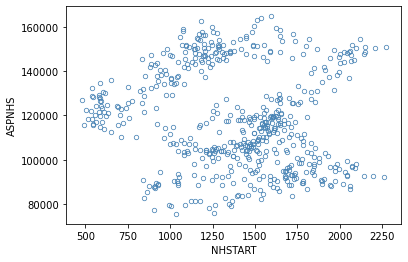

In [22]:
import matplotlib.pyplot as plt

# Convert average selling price to 1982-1984 dollars.
# The value of 100 corresponds to the average price level between 1982-1984.
df['ASPNHS'] /= df['CPI'] / 100.0

df.plot.scatter('NHSTART', 'ASPNHS', linewidths=0.75, color='none',edgecolor='steelblue')

This scatter plot looks somewhat unexpected as there seems to be no clear
relationship between housing supply and house prices. This might be because
the relationship has not remained stable over the decades covered by our data.

To see this more clearly, we bin the time periods into five blocks and
recreate the plots using different colours:

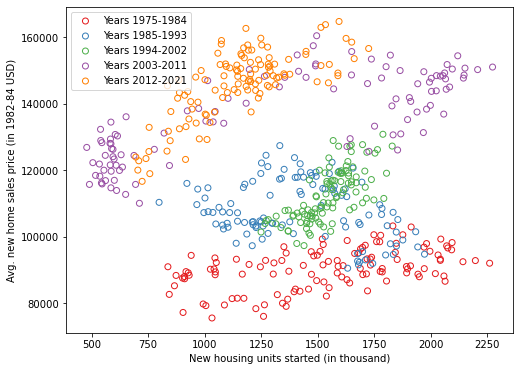

In [23]:
# Create 5 approximately equally-sized bins based on the calendar year
df['Year_bin'] = pd.cut(df['Year'], bins=5, labels=False)

# Plot each group of years using a different color
fig, ax = plt.subplots(1,1, figsize=(8,6))
colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00']

# Iterate over bins, plot each one separately
bins = df['Year_bin'].unique()
for bin in bins:
    # Restrict data set to relevant years
    df_i = df.loc[df['Year_bin'] == bin].copy()

    # Extract initial and terminal year of this block
    yfrom, yto = df_i['Year'].min(), df_i['Year'].max()

    ax.scatter(df_i['NHSTART'], df_i['ASPNHS'], 
        label=f'Years {yfrom:.0f}-{yto:.0f}',
        edgecolors=colors[bin], color='none')

ax.set_xlabel('New housing units started (in thousand)')
ax.set_ylabel('Avg. new home sales price (in 1982-84 USD)')
ax.legend()

del df['Year_bin']

As you see, our suspicion was correct and there are clear changes across
the sample of 45 years. At this point we could do something more elaborate,
but for illustrative purposes we just restrict our analysis to the
period after the year 2000, where we have an upwards-sloping relationship.

### Prepare the data

Before we can call the function `ols()`, we need to pre-process the data
so that we end up with NumPy arrays (the only type of data our function
accepts).

In [24]:
# Keep only relevant variables, rest just clutters the DataFrame
varlist = ['Year', 'Month', 'ASPNHS', 'NHSTART']
df = df[varlist].copy()

# Create YYYY-MM date index
df['Date'] = pd.PeriodIndex(year=df['Year'], month=df['Month'], freq='M')
df = df.set_index('Date')

# Create 3-month, 6-month and 12-month lags of house prices
lags = 3, 6, 12
for lag in lags:
    df[f'L{lag}ASPNHS'] = df['ASPNHS'].shift(lag)

# Restrict data to year >= 2000
df = df.loc[df['Year'] >= 2000].copy()

# Drop year, month, these are no longer needed
df = df.drop(columns=['Year', 'Month'])

# Plot first 13 rows, which clearly shows the lagged values
df.head(13)

,ASPNHS,NHSTART,L3ASPNHS,L6ASPNHS,L12ASPNHS
Date,,,,,
2000-01,118310.691081,1636.0,119095.776324,113437.312537,111050.394657
2000-02,117176.470588,1737.0,125593.824228,115559.545183,116211.293260
2000-03,119824.561404,1604.0,119727.488152,116090.584029,114866.504854
2000-04,121299.005266,1626.0,118310.691081,119095.776324,115852.923448
2000-05,116822.429907,1575.0,117176.470588,125593.824228,113192.771084
2000-06,114808.362369,1559.0,119824.561404,119727.488152,116807.228916
2000-07,117081.644470,1463.0,121299.005266,118310.691081,113437.312537
2000-08,115923.566879,1541.0,116822.429907,117176.470588,115559.545183
2000-09,119988.479263,1507.0,114808.362369,119824.561404,116090.584029


Now that we have created all the lagged variables, we drop all rows with missing data
and convert the relevant columns to NumPy arrays.

In [25]:
# List of variables to include in model
var_X = [f'L{lag}ASPNHS' for lag in lags]
var_y = 'NHSTART'

# Restrict to relevant variables
df = df[var_X + [var_y]].copy()

# drop all rows with missing observations
df = df.dropna()

# Extract raw data from data frame
X = df[var_X].to_numpy()
y = df[var_y].to_numpy()

# Estimate as elasticity in logs
log_X = np.log(X)
log_y = np.log(y)

# Print first 5 observations
log_X[:5]

array([[11.68768329, 11.63900565, 11.61773938],
       [11.74080836, 11.65754122, 11.66316531],
       [11.69297351, 11.66212606, 11.65152591],
       [11.68106942, 11.68768329, 11.66007676],
       [11.67143637, 11.74080836, 11.63684758]])

### Estimating the model

We are now ready to run the OLS regression.

In [26]:
# Run our own ols() function. This returns the coefficient vector and the
# variance-covariance matrix.
coefs, vcv = ols(log_X, log_y, add_const=True)

# Compute standard errors from the VCV matrix
se = np.sqrt(np.diag(vcv))

print(f'Estimated coefficients: {coefs}')
print(f'Standard errors: {se}')
print(f'Number of obs: {len(log_y)}')

Estimated coefficients: [-6.48405842  2.2932615   0.80018127 -1.94803646]
Standard errors: [2.78344134 0.50247618 0.55385034 0.43777545]
Number of obs: 259


### Running OLS using statsmodels

As you can imagine, estimating an OLS regression is a common task so
there are packages which already implement this functionality for you.
One such package is `statsmodels`, which we will now use to verify our
results.

In [27]:
import statsmodels.api as sm

# Explicitly augment the regressor matrix with a constant
log_X1 = sm.add_constant(log_X)

# Define the linear model
model = sm.OLS(log_y, log_X1)

# Estimate the model
result = model.fit()

# Print a summary of the results
result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     19.27
Date:                Fri, 17 Sep 2021   Prob (F-statistic):           2.72e-11
Time:                        14:21:30   Log-Likelihood:                -101.18
No. Observations:                 259   AIC:                             210.4
Df Residuals:                     255   BIC:                             224.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.4841      2.783     -2.330      0.021     -11.966      -1.003
x1             2.2933      0.502      4.564      0.000       1.304       3.283
x2             0.8002      0.554      1.445      0.150      -0.291       1.891
x3            -1.9480      0.438     -4.450      0.000      -2.810      -1.086
==============================================================================
Omnibus:                       31.603   Durbin-Watson:                   0.184
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                9.818
Skew:                          -0.144   Prob(JB):                      0.00738
Kurtosis:                       2.090   Cond. No.                     2.55e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.55e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

As you can see, the point estimates and standard errors are exactly the 
same as the ones we computed.

As for the interpretation, the regression says that a 1% increase in
the average sales price is associated with a 2.3% increase in new house
construction starts in three months time. The elasticity is only 0.8%
if we consider a lag of 6 months (albeit not statistically significant),
and even reverses its sign at a 12-month horizon. This interpretation of course 
assumes that prices are independent over time, which is not overly plausible.
